In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  app.launch_new_instance()


In [2]:
tfidf_path = '../../data/tfidf_20230115_largest_rel/'

In [3]:
lda_path = '../../data/lda_20230115_largest_rel/'

In [4]:
fandom_list = [
 'harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
#  'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
#  'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'marvel',
#  'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms'
]

In [6]:
# df = pd.read_csv(os.path.join(lda_path,'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_no_text.tsv'), sep = '\t')

In [7]:
# len(df)

In [8]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [9]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [10]:
def normalize_dfs(df):
    
    # normalization of the success field
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].fillna(0, inplace=True)
    df['Kudos'].fillna(0, inplace=True)
    df['Bookmarks'].fillna(0, inplace=True)
    df['Comments'].fillna(0, inplace=True)

    # normalize by chapter number
    df['Kudos'] = df['Kudos']/df['Chapters'] 
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Kudos'].dropna()

    df['Hits'].dropna()

    df['Bookmarks'].dropna()
    return df

In [11]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    
    dic = {}
    dic_top5p = {}
    dic_bot5p = {}
    
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        
        top_5p = np.percentile(df_s[suc_field], 95)
        df_top5p = df_s[df_s[suc_field] > top_5p]
        
    
        bot_5p = np.percentile(df_s[suc_field], 5)
        df_bot5p = df_s[df_s[suc_field] < bot_5p]
    
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
            
        
        li_top5p = df_top5p[suc_field].tolist()
        if len(li_top5p) > 0:
            if metric == 'ave':
                dic_top5p[term_n[i]] = ave_bootstrap_resample(li_top5p)
            elif metric == 'var':
                dic_top5p[term_n[i]] = var_bootstrap_resample(li_top5p)
        else:
            dic_top5p[term_n[i]] = (0, 0, 0)
                
        li_bot5p = df_bot5p[suc_field].tolist()
        if len(li_bot5p) > 0:
            if metric == 'ave':
                dic_bot5p[term_n[i]] = ave_bootstrap_resample(li_bot5p)
            elif metric == 'var':
                dic_bot5p[term_n[i]] = var_bootstrap_resample(li_bot5p)
        else:
            dic_bot5p[term_n[i]] = (0, 0, 0)
            
    return dic, dic_top5p, dic_bot5p

In [20]:
def generate_res_term(path, metric):

    df_all = []
    for fandom in fandom_list:
        df = pd.read_csv(os.path.join(path,fandom + \
                                  '_tfidf_merged_chapters_20230115_largest_rel.tsv'), sep = '\t')
    
        df = normalize_dfs(df)
        df = df[df.Hits >= 1]
        df['kudos_hit_ratio'] = df['Kudos']/df['Hits']  

        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[['Cos', 'kudos_hit_ratio']].dropna()
        
        df_all.append(df)
        
    df_all = pd.concat(df_all)

    dic, dic_top5p, dic_bot5p = create_dict(df=df_all, nov_field='Cos', suc_field='kudos_hit_ratio', metric=metric)

    return dic, dic_top5p, dic_bot5p
    

In [21]:
def generate_res_topic(path, metric):

    df_all = []
    for fandom in fandom_list:
        
        df = pd.read_csv(os.path.join(path,fandom + \
                                  '_lda_with_dist_merged_chs_20230115_largest_rel.tsv'), sep = '\t')
        df = normalize_dfs(df)
        df = df[df.Hits >= 10]
        df['kudos_hit_ratio'] = df['Kudos']/df['Hits']  

        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[['JSD', 'kudos_hit_ratio']].dropna()
        
        df_all.append(df)

    df_all = pd.concat(df_all)

    dic, dic_top5p, dic_bot5p = create_dict(df=df_all, nov_field='JSD', suc_field='kudos_hit_ratio', metric=metric)

    return dic, dic_top5p, dic_bot5p
    

In [22]:
def generate_dics():
    tfidf_kudos_dict_var, tfidf_kudos_dict_var_top5p, tfidf_kudos_dict_var_bot5p = generate_res_term(tfidf_path, 'var')

    tfidf_kudos_dict_ave, tfidf_kudos_dict_ave_top5p, tfidf_kudos_dict_ave_bot5p = generate_res_term(tfidf_path, 'ave')
    
    lda_kudos_dict_var, lda_kudos_dict_var_top5p, lda_kudos_dict_var_bot5p = generate_res_topic(lda_path,  'var')

    lda_kudos_dict_ave, lda_kudos_dict_ave_top5p, lda_kudos_dict_ave_bot5p = generate_res_topic(lda_path, 'ave')

    
    return tfidf_kudos_dict_var, tfidf_kudos_dict_var_top5p, tfidf_kudos_dict_var_bot5p,\
            tfidf_kudos_dict_ave, tfidf_kudos_dict_ave_top5p, tfidf_kudos_dict_ave_bot5p,\
            lda_kudos_dict_var, lda_kudos_dict_var_top5p, lda_kudos_dict_var_bot5p, \
            lda_kudos_dict_ave, lda_kudos_dict_ave_top5p, lda_kudos_dict_ave_bot5p 

In [23]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [24]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [25]:
tfidf_kudos_dict_var, tfidf_kudos_dict_var_top5p, tfidf_kudos_dict_var_bot5p,\
    tfidf_kudos_dict_ave, tfidf_kudos_dict_ave_top5p, tfidf_kudos_dict_ave_bot5p,\
    lda_kudos_dict_var, lda_kudos_dict_var_top5p, lda_kudos_dict_var_bot5p, \
    lda_kudos_dict_ave, lda_kudos_dict_ave_top5p, lda_kudos_dict_ave_bot5p =  generate_dics()

In [26]:
tfidf_kudos_dict_var

{0.0: (0.001397136989554487, 0.0013465610521538024, 0.0014428810323113864),
 0.0960238515648382: (0.0015179136161135687,
  0.0014822750029243113,
  0.001569864756185051),
 0.1206810177105904: (0.0015582759320153716,
  0.0015134775744410894,
  0.0015970530142550292),
 0.143852363857486: (0.0015545954280291132,
  0.0015167853157853572,
  0.001606182039711118),
 0.1690866149073618: (0.0014272401872178764,
  0.001380840872480743,
  0.001467393244402076),
 0.2001020562345691: (0.0012849265387225028,
  0.0012455814124434528,
  0.0013195540103911484),
 0.2423105784859656: (0.0011074219565814772,
  0.0010694639064194635,
  0.0011481405670194522),
 0.2991079711247309: (0.0011984386988830897,
  0.0011468098541458365,
  0.0012572407774929135),
 0.360257147786112: (0.0012459193290285733,
  0.001202019171882991,
  0.0012905752135230508),
 0.4359848469060162: (0.0013022111533417902,
  0.0012594724496078902,
  0.001348235895545081)}

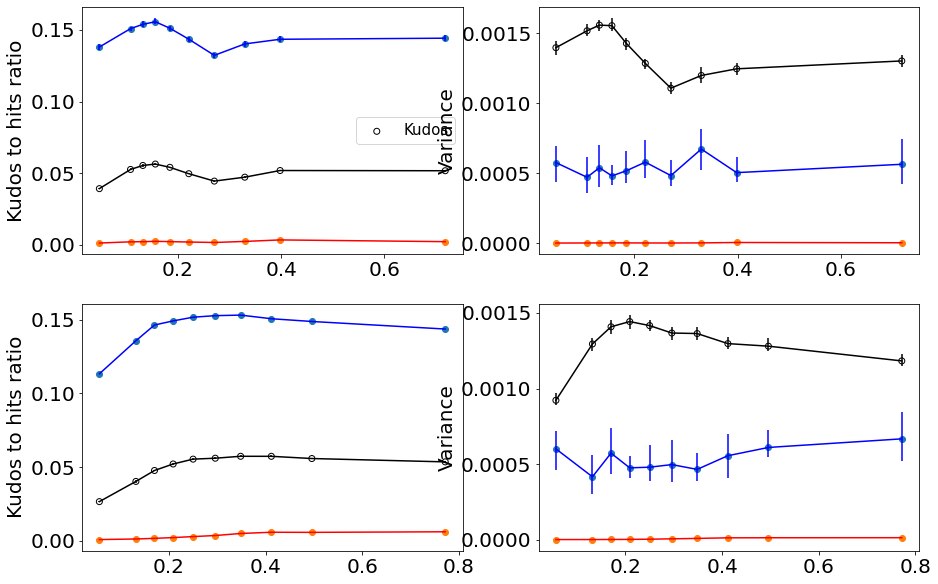

In [27]:

    

fig, axes = plt.subplots(2,2,figsize = (15,10))

#################subplot 1################
x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
axes[0][0].errorbar(x, y, yerr=err, color='black')
axes[0][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x_top5p, y_top5p, err_top5p = extract_plot_vals(tfidf_kudos_dict_ave_top5p)
axes[0][0].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
axes[0][0].scatter(x_top5p, y_top5p)  

x_bot5p, y_bot5p, err_bot5p = extract_plot_vals(tfidf_kudos_dict_ave_bot5p)
axes[0][0].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
axes[0][0].scatter(x_bot5p, y_bot5p)

axes[0][0].legend(prop={'size': 15})
axes[0][0].set_ylabel('Kudos to hits ratio',fontsize=20)
axes[0][0].tick_params(labelsize=20)


#################subplot 2################

x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
axes[0][1].errorbar(x, y, yerr=err, color='black')
axes[0][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x_top5p, y_top5p, err_top5p = extract_plot_vals(tfidf_kudos_dict_var_top5p)
axes[0][1].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
axes[0][1].scatter(x_top5p, y_top5p)

x_bot5p, y_bot5p, err_bot5p = extract_plot_vals(tfidf_kudos_dict_var_bot5p)
axes[0][1].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
axes[0][1].scatter(x_bot5p, y_bot5p)

axes[0][1].set_ylabel('Variance',fontsize=20)
# plt.legend()
axes[0][1].tick_params(labelsize=20)
# axes[0][1].set_title(fandom, fontsize=20)

#################subplot 3################

x, y, err = extract_plot_vals(lda_kudos_dict_ave)
axes[1][0].errorbar(x, y, yerr=err, color='black')
axes[1][0].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x_top5p, y_top5p, _ = extract_plot_vals(lda_kudos_dict_ave_top5p)
axes[1][0].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
axes[1][0].scatter(x_top5p, y_top5p)    

x_bot5p, y_bot5p, _ = extract_plot_vals(lda_kudos_dict_ave_bot5p)
axes[1][0].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
axes[1][0].scatter(x_bot5p, y_bot5p)

# plt.legend(prop={'size': 15})
axes[1][0].set_ylabel('Kudos to hits ratio',fontsize=20)
axes[1][0].tick_params(labelsize=20)

#################subplot 4################

x, y, err = extract_plot_vals(lda_kudos_dict_var)
axes[1][1].errorbar(x, y, yerr=err, color='black')
axes[1][1].scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='black')

x_top5p, y_top5p, _ = extract_plot_vals(lda_kudos_dict_var_top5p)
axes[1][1].errorbar(x_top5p, y_top5p, yerr=err_top5p, color='blue')
axes[1][1].scatter(x_top5p, y_top5p) 

x_bot5p, y_bot5p, _ = extract_plot_vals(lda_kudos_dict_var_bot5p)
axes[1][1].errorbar(x_bot5p, y_bot5p, yerr=err_bot5p, color='red')
axes[1][1].scatter(x_bot5p, y_bot5p)

axes[1][1].set_ylabel('Variance',fontsize=20)
axes[1][1].tick_params(labelsize=20)

